In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.base import BaseEstimator

In [2]:
df = pd.read_csv('train_modelling_rfe.csv')
df

,full_sq,num_room,state,culture_objects_top_25,build_count_monolith,ttk_km,railroad_km,cafe_count_500_na_price,cafe_count_1000_price_high,trc_count_1500,...,avg_dist_to_amenities,area_density,area_diff_sq,median_max_floor,max_floor_ratio,cpi,gdp_annual_growth,usdrub,invest_fixed_capital_per_cap,price_doc
0,43.0,2.0,2.0,0,2.0,10.918587,1.305159,0,0,9,...,3.464517,0.024279,47.993349,12.0,1.019467,354.0,0.045037,29.0048,73976.19863,5850000
1,34.0,2.0,2.0,1,4.0,3.103996,0.694536,0,0,7,...,2.336570,0.012029,47.993349,18.0,1.019467,354.0,0.045037,28.9525,73976.19863,6000000
2,43.0,2.0,2.0,0,4.0,2.927487,0.700691,0,0,1,...,0.778705,0.021153,47.993349,12.0,1.019467,354.0,0.045037,28.8082,73976.19863,5700000
3,89.0,2.0,2.0,0,50.0,14.606501,1.999265,0,0,7,...,2.509353,0.014183,47.993349,17.0,1.019467,353.2,0.045037,28.9655,73976.19863,13100000
4,77.0,2.0,2.0,0,16.0,1.721834,0.084113,3,1,9,...,1.658507,0.012880,47.993349,7.0,1.019467,353.2,0.045037,29.4625,73976.19863,16331452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30466,44.0,2.0,3.0,0,5.0,8.361875,1.137603,1,0,6,...,2.748987,0.017459,38.000000,12.0,0.750000,489.5,0.007065,55.2655,131403.00000,7400000
30467,86.0,4.0,3.0,1,25.0,1.238732,0.377368,3,1,7,...,1.383730,0.010315,76.000000,17.0,0.529412,489.5,0.007065,55.2655,131403.00000,25000000
30468,45.0,1.0,1.0,0,6.0,17.148737,1.727223,0,0,0,...,5.626612,0.000157,44.000000,17.0,1.176471,489.5,0.007065,55.2655,131403.00000,6970959
30469,64.0,2.0,2.0,0,9.0,8.940313,4.898047,0,0,1,...,1.297676,0.012994,53.000000,17.0,0.882353,489.5,0.007065,55.2655,131403.00000,13500000


In [3]:
X = df.drop("price_doc", axis=1)
y = df["price_doc"]

In [4]:
class ClusterAndPredict(BaseEstimator):
    
    def __init__(self, k):
        self.k = k
    
    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        kmeans = KMeans(n_clusters=self.k)
        kmeans.fit(X_train)
        X_train['cluster_label'] = kmeans.labels_

        linear_regression_models = {}

        for cluster_label in range(self.k):
            X_cluster = X_train[X_train['cluster_label'] == cluster_label].drop('cluster_label', axis=1)
            y_cluster = y_train[X_train['cluster_label'] == cluster_label]
            reg = LinearRegression()
            reg.fit(X_cluster, y_cluster)
            linear_regression_models[cluster_label] = reg

        X_test['predicted_cluster_label'] = kmeans.predict(X_test)
        X_test['predicted_price_doc'] = X_test['predicted_cluster_label'].map(lambda x: linear_regression_models[x].predict(X_test[X_test['predicted_cluster_label'] == x].drop(['predicted_cluster_label'], axis=1))[0])

        self.mse_ = mean_squared_error(y_test, X_test['predicted_price_doc'])
        
        return self

    def score(self, X, y):
        return -self.mse_

In [5]:
param_grid = {'k': range(1, 51)}
estimator = ClusterAndPredict(k=None)

grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5, estimator=ClusterAndPredict(k=None),
             param_grid={'k': range(1, 51)})

In [6]:
best_k = grid_search.best_params_['k']
best_mse = -grid_search.best_score_

print("Best k: ", best_k)
print("Best MSE: ", best_mse)

Best k:  1
Best MSE:  25459943048941.617


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_train)
X_train['cluster_label'] = kmeans.labels_

linear_regression_models = {}

for cluster_label in range(2):
    X_cluster = X_train[X_train['cluster_label'] == cluster_label].drop('cluster_label', axis=1)
    y_cluster = y_train[X_train['cluster_label'] == cluster_label]
    reg = LinearRegression()
    reg.fit(X_cluster, y_cluster)
    linear_regression_models[cluster_label] = reg

X_test['predicted_cluster_label'] = kmeans.predict(X_test)
y_pred = X_test['predicted_cluster_label'].map(lambda x: linear_regression_models[x].predict(X_test[X_test['predicted_cluster_label'] == x].drop(['predicted_cluster_label'], axis=1))[0])


In [14]:
print("MSE: ", mean_squared_error(y_test, y_pred))
print("RMSE: ", mean_squared_error(y_test, y_pred)**0.5)
print("MSLE: ", mean_squared_log_error(y_test, y_pred))
print("RMSLE: ", mean_squared_log_error(y_test, y_pred)**0.5)

MSE:  25439724538854.348
RMSE:  5043780.778231182
MSLE:  0.3526392481801429
RMSLE:  0.5938343608954798


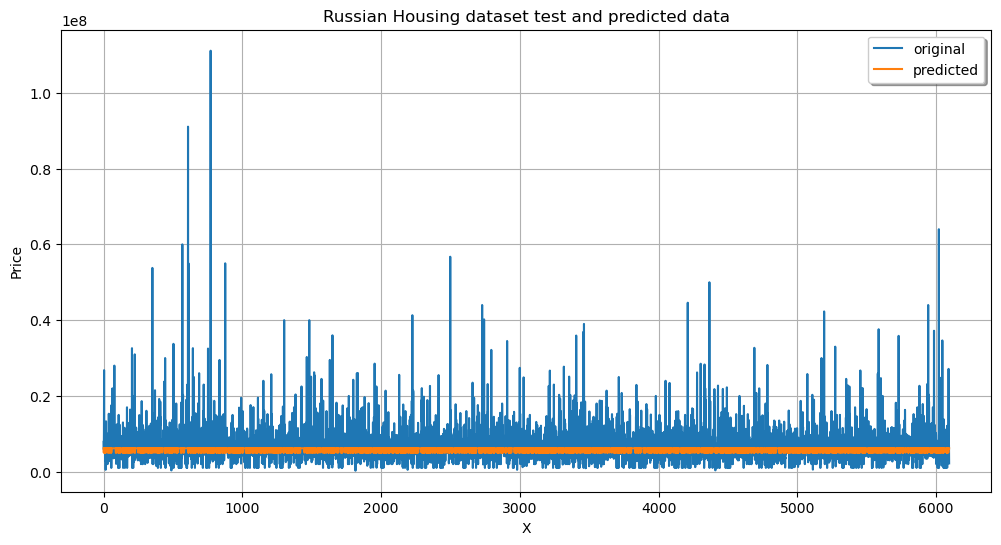

In [15]:
x_ax = range(len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Russian Housing dataset test and predicted data")
plt.xlabel('X')
plt.ylabel('Price')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()